In [6]:
# from google.colab import drive
import os
from PIL import Image
import numpy as np
import torch
from tqdm import tqdm
import torch
from torchvision import transforms
from transformers import pipeline
import cv2
import matplotlib.pyplot as plt
import timm

# DPT-Hybrid 모델 로드
dpt_model_path = "dpt_hybrid-midas-501f0c75.pt"
dpt_model = torch.hub.load("intel-isl/MiDaS", "DPT_Hybrid", path=dpt_model_path)
dpt_model.eval()

# Depth-Large 모델 로드
dpt_large_path = "dpt_large-midas-2f21e586.pt"
dpt_large_model = torch.hub.load("intel-isl/MiDaS", "DPT_Large", path=dpt_large_path)
dpt_large_model.eval()

# 깊이 추정 파이프라인 로드
checkpoint = "depth-anything/Depth-Anything-V2-base-hf"
pipe = pipeline("depth-estimation", model=checkpoint)



Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_hybrid_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_hybrid_384.pt
100%|██████████| 470M/470M [00:02<00:00, 194MB/s]
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_large_384.pt
100%|██████████| 1.28G/1.28G [00:36<00:00, 37.6MB/s]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), s

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/390M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [49]:
import torch
from tqdm import tqdm

def process_single_image(image_path, rgb_output_path, depth_output_path, rgbd_output_path):
    # 이미지 파일 이름 추출
    image_file = os.path.basename(image_path)

    # 이미지 열기
    image = Image.open(image_path)

    # 파일 이름 생성
    class_name = 'mouse'  # 파일 이름을 클래스 이름으로 사용

    # RGB 이미지를 numpy 배열로 변환
    rgb_image = np.array(image)

    # RGB 이미지를 0-255 범위로 정규화 (필요한 경우)
    if rgb_image.max() > 255:  # 정규화가 필요한 경우
        rgb_image_normalized = (rgb_image * 255 / rgb_image.max()).astype('uint8')
    else:
        rgb_image_normalized = rgb_image

    # RGB 이미지를 PIL 이미지로 변환
    rgb_image_pil = Image.fromarray(rgb_image_normalized)

    # RGB 이미지를 저장
    rgb_image_filename = f"rgb_{class_name}.jpg"
    rgb_image_pil.save(os.path.join(rgb_output_path, rgb_image_filename))

    # 깊이 추정 예측 (여기서 pipe는 미리 정의된 모델입니다)
    predictions = pipe(image)

    # 깊이 맵을 numpy 배열로 변환
    depth_map = predictions['predicted_depth'].squeeze().cpu().numpy()

    # 깊이 맵을 0-255 범위로 정규화하여 흑백 이미지로 저장
    normalized_depth_map = (depth_map * 255 / depth_map.max()).astype('uint8')
    depth_map_image = Image.fromarray(normalized_depth_map)

    # 깊이 맵 크기를 RGB 이미지 크기에 맞게 조정
    depth_map_resized = depth_map_image.resize(image.size, Image.ANTIALIAS)
    depth_map_filename = f"depth_{class_name}.png"
    depth_map_resized.save(os.path.join(depth_output_path, depth_map_filename))

    # RGB 이미지 크기를 깊이 맵 크기에 맞게 조정
    rgb_image_resized = rgb_image_pil.resize(depth_map_resized.size, Image.ANTIALIAS)

    # 깊이 맵 크기와 동일한 RGB 이미지와 깊이 맵을 결합하여 RGBD 이미지 생성
    rgbd_image = np.dstack((np.array(rgb_image_resized), np.array(depth_map_resized)))

    # RGBD 이미지를 저장
    rgbd_image_filename = f"rgbd_{class_name}.png"
    rgbd_image_pil = Image.fromarray(rgbd_image)
    rgbd_image_pil.save(os.path.join(rgbd_output_path, rgbd_image_filename))

    return np.array(depth_map_resized)

In [18]:
# 이미지 로드 및 전처리
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)
    return image

# Depth 추정
def estimate_depth(image_path, model):
    image = load_image(image_path)
    with torch.no_grad():
        depth = model(image)
    depth = depth.squeeze().numpy()
    return depth

In [39]:
# 원본 이미지와 Depth 이미지를 시각화하는 함수
def plot_images_with_depth(image_path, depth1, depth2, depth3):
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR 포맷을 사용하므로 RGB로 변환
    depth_resized1 = cv2.resize(depth1, (original_image.shape[1], original_image.shape[0]))
    depth_resized2 = cv2.resize(depth2, (original_image.shape[1], original_image.shape[0]))
    # depth3 = depth3.squeeze().cpu().numpy()
    depth_resized3 = cv2.resize(depth3, (original_image.shape[1], original_image.shape[0]))

    fig, axs = plt.subplots(1, 4, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 1, 1, 1]})

    axs[0].imshow(original_image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    im1 = axs[1].imshow(depth_resized1, cmap='inferno')
    axs[1].set_title('DPT-Hybrid')
    axs[1].axis('off')

    im2 = axs[2].imshow(depth_resized2, cmap='inferno')
    axs[2].set_title('DPT-Large')
    axs[2].axis('off')

    im3 = axs[3].imshow(depth_resized3, cmap='inferno')
    axs[3].set_title('Depth-Anything')
    axs[3].axis('off')

    cbar = fig.colorbar(im3, ax=axs, orientation='horizontal', fraction=.02, pad=0.04)
    cbar.set_label('Depth')

    plt.tight_layout()
    plt.show()

In [27]:
# 이미지 로드
image_path = "ning1.jpg"
rgb_output_path = "/content/"
depth_output_path = "/content/"
rgbd_output_path = "/content/"
dpt_hybrid_depth = estimate_depth(image_path, dpt_model)
dpt_large_depth = estimate_depth(image_path, dpt_large_model)
depth_anything_depth = process_single_image(image_path, rgb_output_path, depth_output_path, rgbd_output_path)

<ipython-input-23-cbe7b91ee3da>:41: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  depth_map_resized = depth_map_image.resize(image.size, Image.ANTIALIAS)
<ipython-input-23-cbe7b91ee3da>:46: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  rgb_image_resized = rgb_image_pil.resize(depth_map_resized.size, Image.ANTIALIAS)


<ipython-input-39-025911671806>:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


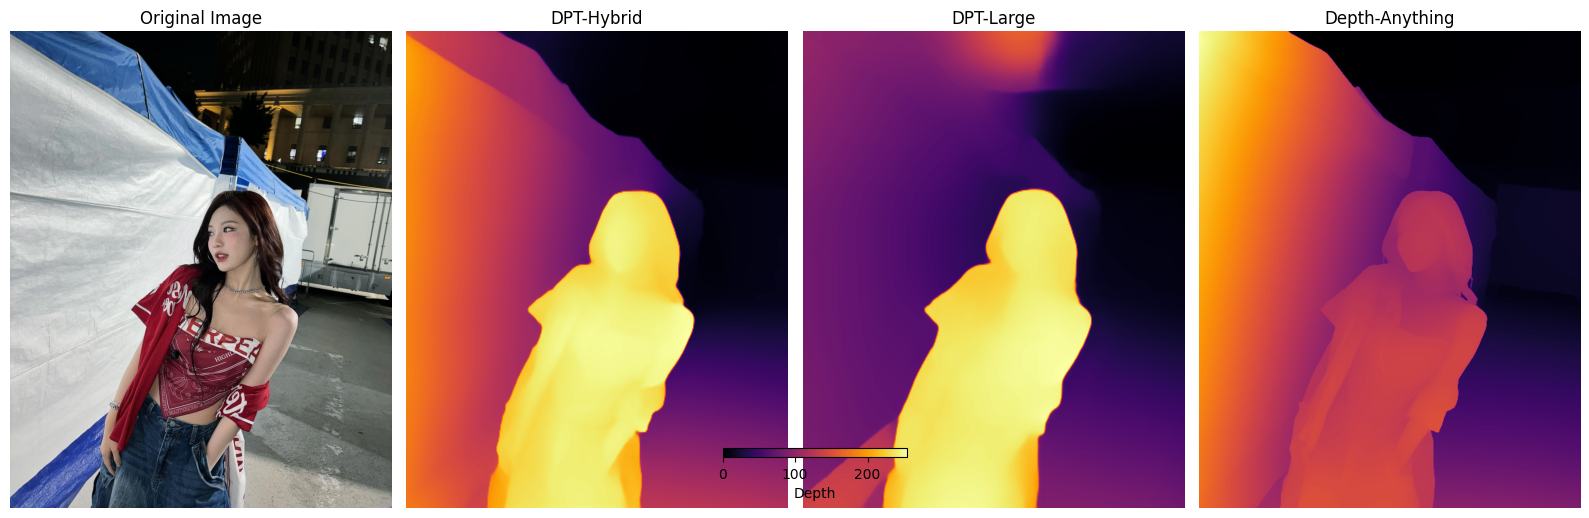

In [40]:
# 시각화
plot_images_with_depth(image_path, dpt_hybrid_depth, dpt_large_depth, depth_anything_depth)

In [42]:
# 이미지 로드
image_path = "cat.jpg"
rgb_output_path = "/content/"
depth_output_path = "/content/"
rgbd_output_path = "/content/"
dpt_hybrid_depth = estimate_depth(image_path, dpt_model)
dpt_large_depth = estimate_depth(image_path, dpt_large_model)
depth_anything_depth = process_single_image(image_path, rgb_output_path, depth_output_path, rgbd_output_path)

<ipython-input-41-875887e4a601>:41: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  depth_map_resized = depth_map_image.resize(image.size, Image.ANTIALIAS)
<ipython-input-41-875887e4a601>:46: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  rgb_image_resized = rgb_image_pil.resize(depth_map_resized.size, Image.ANTIALIAS)


<ipython-input-39-025911671806>:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


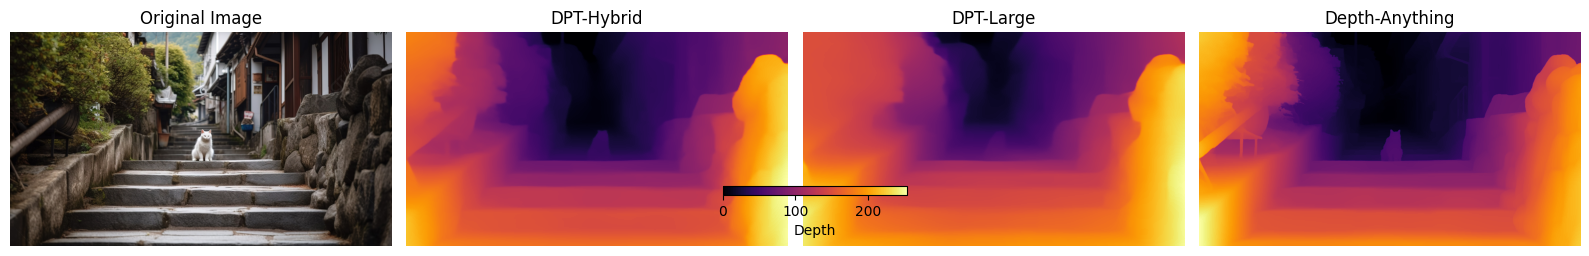

In [43]:
# 시각화
plot_images_with_depth(image_path, dpt_hybrid_depth, dpt_large_depth, depth_anything_depth)

In [52]:
# from google.colab import drive
# drive.mount('/content/drive')
image_path = "mouse_image.jpg"
rgb_output_path = "/content/drive/MyDrive/data"
depth_output_path = "/content/drive/MyDrive/data"
rgbd_output_path = "/content/drive/MyDrive/data"
dpt_hybrid_depth = estimate_depth(image_path, dpt_model)
dpt_large_depth = estimate_depth(image_path, dpt_large_model)
depth_anything_depth = process_single_image(image_path, rgb_output_path, depth_output_path, rgbd_output_path)

<ipython-input-49-5207876bd529>:41: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  depth_map_resized = depth_map_image.resize(image.size, Image.ANTIALIAS)
<ipython-input-49-5207876bd529>:46: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  rgb_image_resized = rgb_image_pil.resize(depth_map_resized.size, Image.ANTIALIAS)
